In [1]:
!pip install -U layoutparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-ubu7lfgb/detectron2_03234c84536c417cbc92da408a7e672a
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-ubu7lfgb/detectron2_03234c84536c417cbc92da408a7e672a
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1


In [3]:
!pip install layoutparser[ocr]     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!git clone https://github.com/Layout-Parser/layout-parser.git

fatal: destination path 'layout-parser' already exists and is not an empty directory.


### Reading a sample image from the dataset

In [6]:
import cv2
image = cv2.imread("/content/layout-parser/examples/data/example-table.jpeg")
image = image[..., ::-1] 

### Importing Layout-Parsor library, which is a library focused towards detecting text, tiltle, list, table and figure from a sample image

In [7]:
import layoutparser as lp

Downgrading the existing python version in the system

In [8]:
pip install --upgrade pillow==6.2.2 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-6.2.2-cp38-cp38-manylinux1_x86_64.whl (2.1 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.3.0
    Uninstalling Pillow-9.3.0:
      Successfully uninstalled Pillow-9.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytesseract 0.3.10 requires Pillow>=8.0.0, but you have pillow 6.2.2 which is incompatible.
pdfplumber 0.7.6 requires Pillow>=9.1, but you have pillow 6.2.2 which is incompatible.
detectron2 0.4 requires Pillow>=7.1, but you have pillow 6.2.2 which is incompatible.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 6.2.2 which is incompatible.


### The model is trained using the dataset and maps are created to distinguish between several different objects in the image
Documentation link - https://layout-parser.readthedocs.io/en/latest/

In [9]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

### The classification is illustrated below as the model successfully distinguishes beween the title and table in the image

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


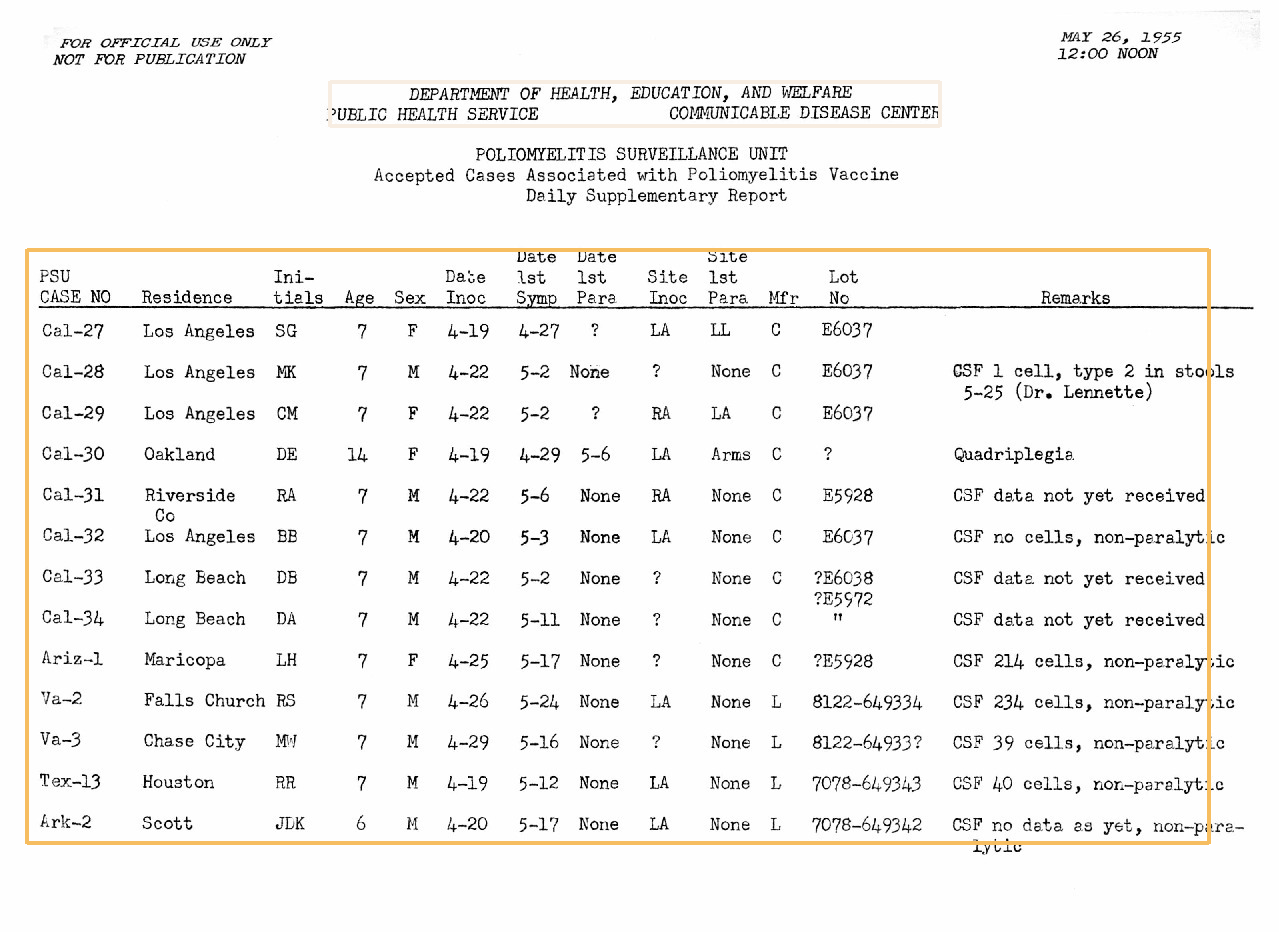

In [10]:
layout = model.detect(image) 
lp.draw_box(image, layout,)

### The coordinates for the table are extrated and accuracy is obtained as 97%

In [11]:
text_blocks = lp.Layout([b for b in layout if b.type=="Table"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=27.745519638061523, y_1=249.892578125, x_2=1208.8997802734375, y_2=843.3308715820312), text=None, id=None, type=Table, parent=None, next=None, score=0.9762899279594421)], page_data={})

### Similarly coordinates for Figure are tried to be extrated, but due to absence of any figure in the image, the cooredinates are empty

In [12]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [13]:
figure_blocks

Layout(_blocks=[], page_data={})

In [14]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

## Specific coordinates of the table are extrated and the table is maped in the image

In [15]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

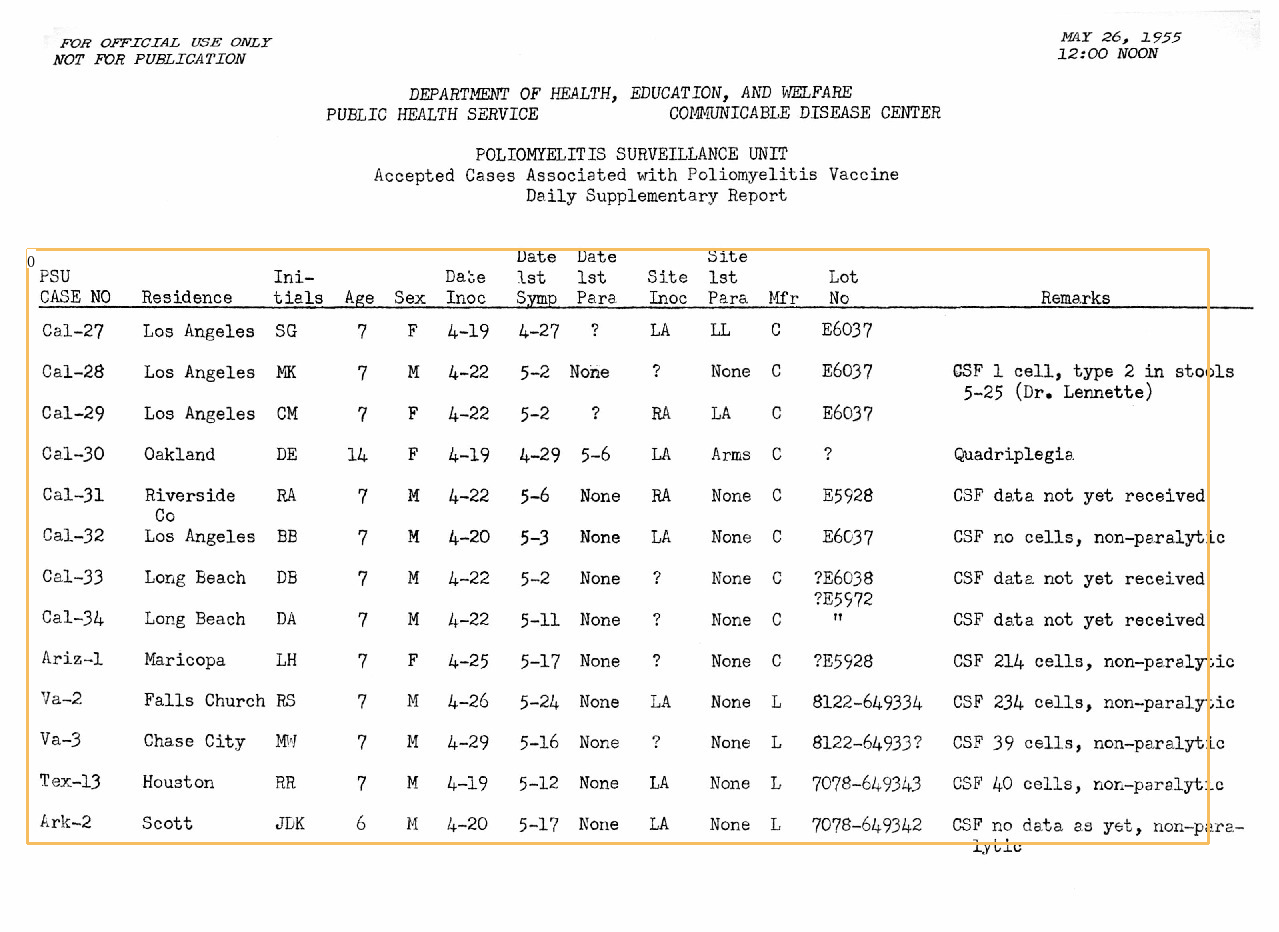

In [16]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [17]:
ocr_agent = lp.TesseractAgent(languages='eng') 

In [18]:
!sudo apt install tesseract-ocr


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


## Now the goal is to extratct text from the image

In [19]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [20]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

 

Date Date Site
PSU Ini- Date Ast lst ist Lot
CASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks
Cal-27 Los Angeles SG F419 4-27? LL £6037
Cal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc

5-25 (Dr. Lennette)

Cal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037
Cal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia
Cal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received
Cal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;
Gel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received
Cal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received
Ariz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt
Va-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt
Va-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 39 cells, non-paralyti
Tex-13 Houston RR 7 M 4-19 5-12 None None 7078-64.9343 CSF 40 cells, nor—parelyti
Ark~2 Scott DK 

In [21]:
text_blocks.get_texts()


[' \n\nDate Date Site\nPSU Ini- Date Ast lst ist Lot\nCASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks\nCal-27 Los Angeles SG F419 4-27? LL £6037\nCal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc\n\n5-25 (Dr. Lennette)\n\nCal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037\nCal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia\nCal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received\nCal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;\nGel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received\nCal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received\nAriz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt\nVa-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt\nVa-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 39 cells, non-paralyti\nTex-13 Houston RR 7 M 4-19 5-12 None None 7078-64.9343 CSF 40 cells, nor—par

In [22]:
for block in text_blocks:
  print(block)

TextBlock(block=Rectangle(x_1=27.745519638061523, y_1=249.892578125, x_2=1208.8997802734375, y_2=843.3308715820312), text= 

Date Date Site
PSU Ini- Date Ast lst ist Lot
CASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks
Cal-27 Los Angeles SG F419 4-27? LL £6037
Cal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc

5-25 (Dr. Lennette)

Cal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037
Cal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia
Cal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received
Cal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;
Gel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received
Cal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received
Ariz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt
Va-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt
Va-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CS

In [23]:
!pip install spacy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf
!pip install click==7.1.1
!pip install spacy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-28 19:19:30.073616: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 460.3 MB 22 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import spacy
nlp = spacy.load("en_core_web_trf")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [26]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]


In [27]:
".".join(sentence)  


' \n\nDate Date Site\nPSU Ini- Date Ast lst ist Lot\nCASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks\nCal-27 Los Angeles SG F419 4-27? LL £6037\nCal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc\n\n5-25 (Dr. Lennette)\n\nCal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037\nCal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia\nCal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received\nCal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;\nGel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received\nCal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received\nAriz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt\nVa-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt\nVa-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 39 cells, non-paralyti\nTex-13 Houston RR 7 M 4-19 5-12 None None 7078-64.9343 CSF 40 cells, nor—pare

## Using NLP the text is joined 

In [28]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)

Los Angeles GPE
Los Angeles GPE
1 CARDINAL
2 CARDINAL
Lennette PERSON
Los Angeles GPE
Oakland GPE
Long Beach GPE
214 CARDINAL
Falls Church GPE
Chase City GPE
39 CARDINAL
40 CARDINAL


## This section contains an example of a more complex image containing various elements

In [29]:
image2 = cv2.imread("/content/layout-parser/examples/data/paper-image.jpg")
image2 = image2[..., ::-1] 

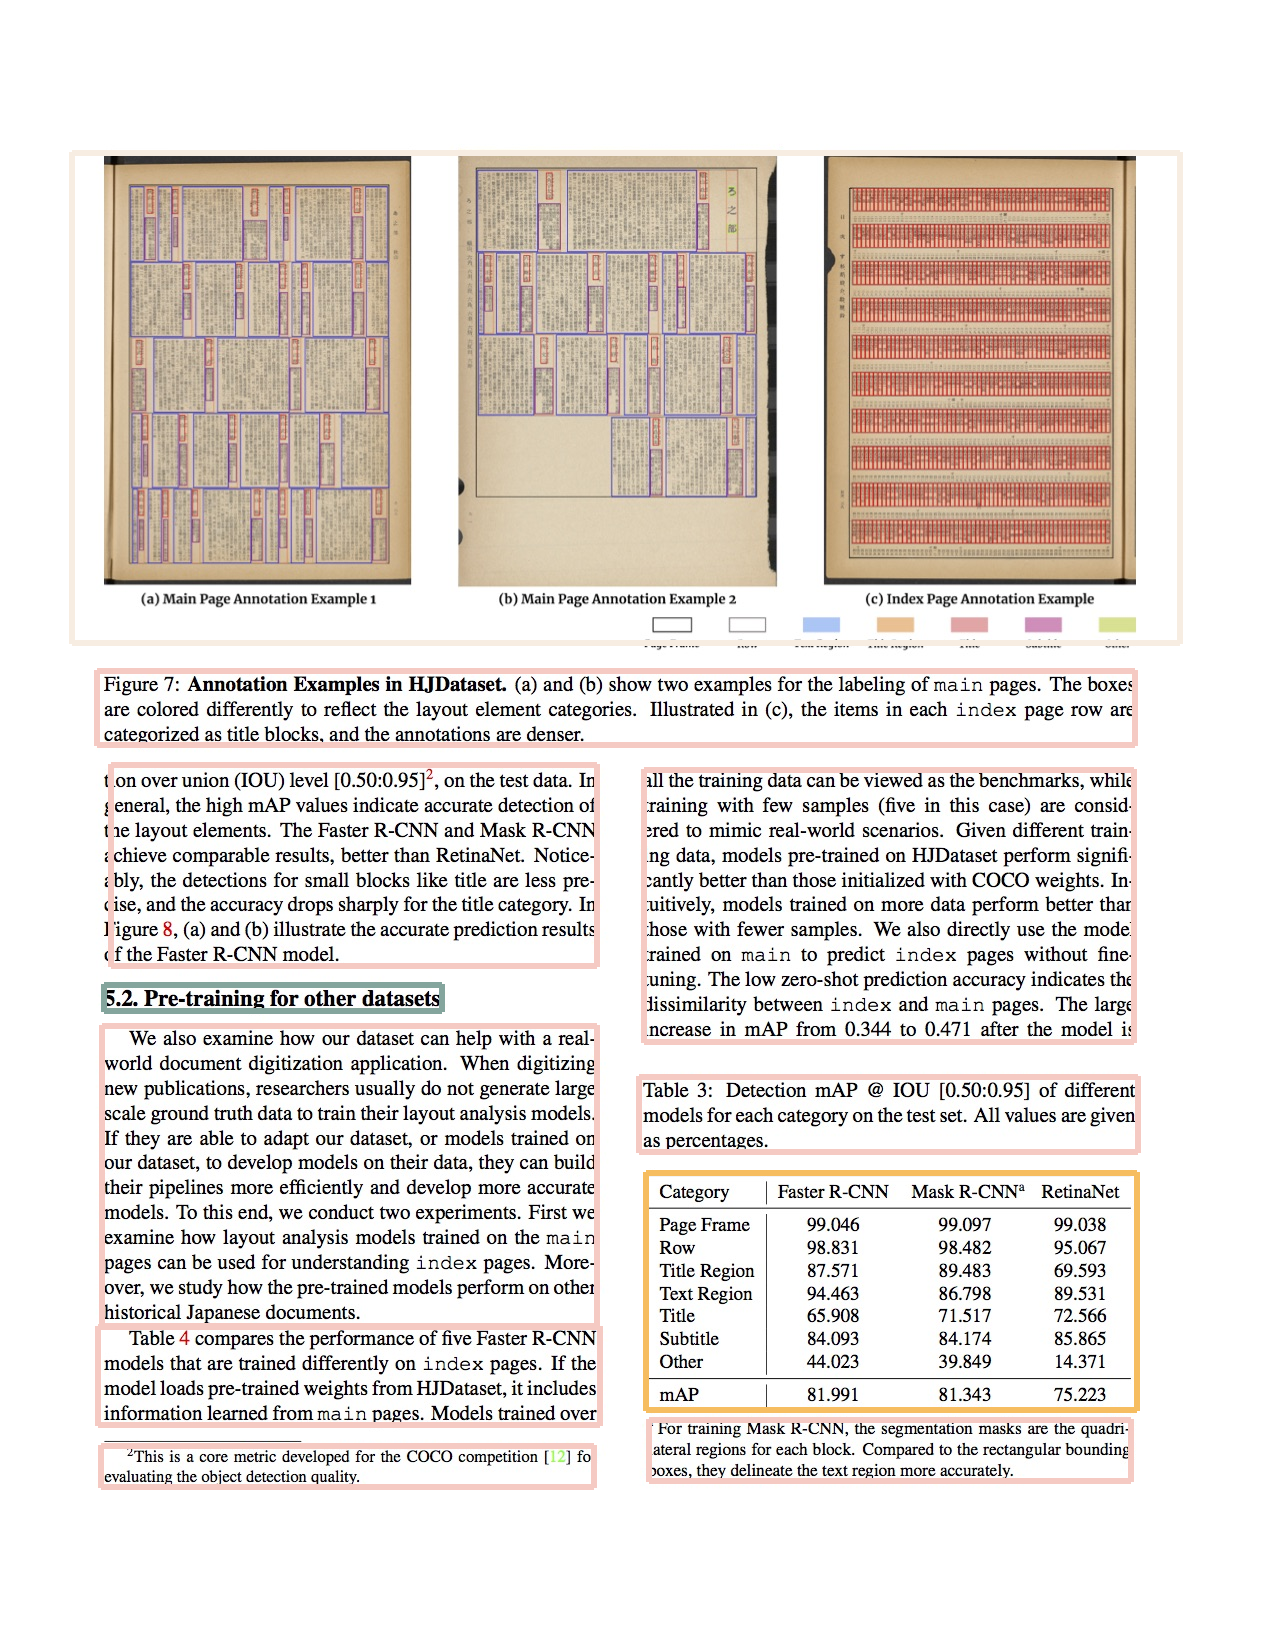

In [30]:
layout = model.detect(image2) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image2, layout,)

##Model achieved an accuracy of 98%

In [31]:
text_blocks = lp.Layout([b for b in layout if b.type=="Title"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=104.18395233154297, y_1=984.3191528320312, x_2=441.509521484375, y_2=1011.412841796875), text=None, id=None, type=Title, parent=None, next=None, score=0.9871368408203125)], page_data={})

In [32]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

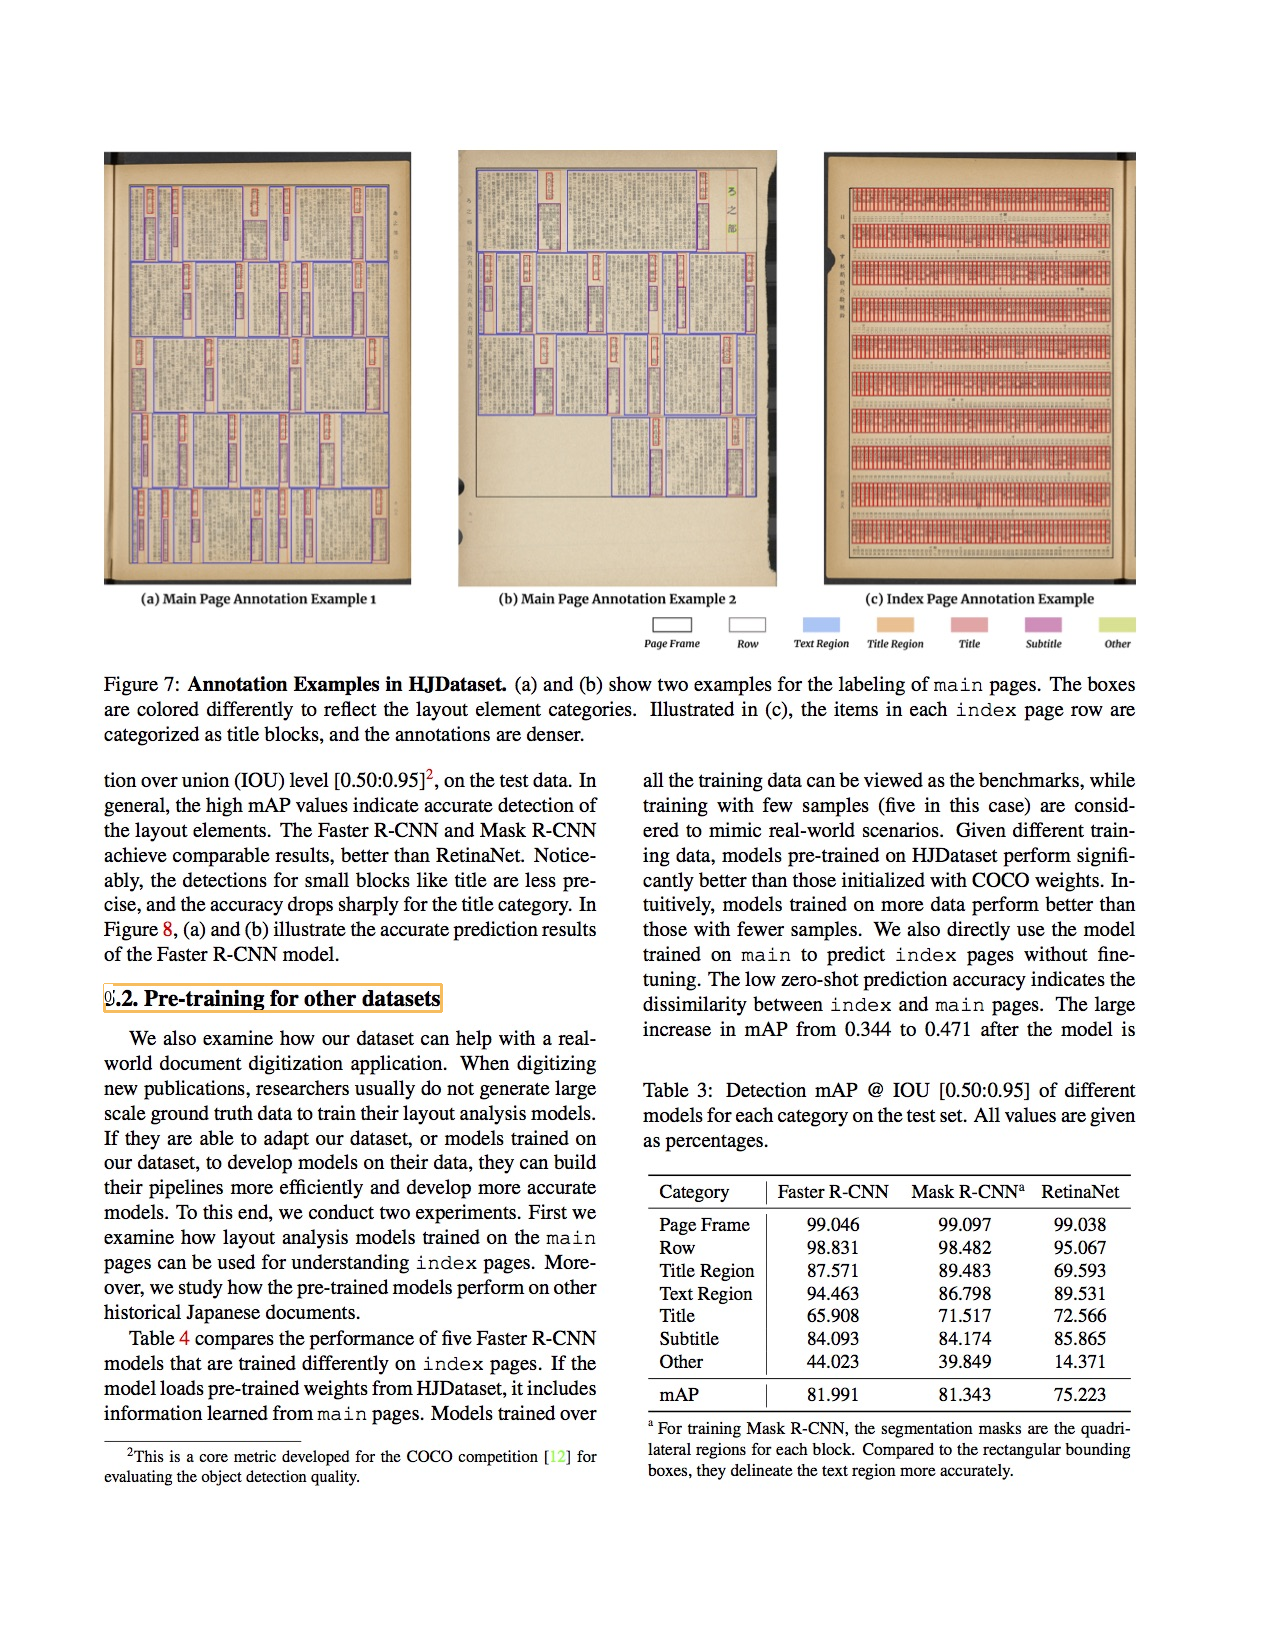

In [33]:
lp.draw_box(image2, text_blocks,
            box_width=3, 
            show_element_id=True)
     